In [ ]:
pip install --upgrade pip

In [ ]:
pip install -U langgraph langchain_openai

In [40]:
model_name = "gpt-4o-mini"  #gpt-4o-mini #gpt-3.5-turbo

In [41]:
import os
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage


from pydantic import BaseModel, Field

In [42]:
from tempfile import TemporaryDirectory
from langchain_community.agent_toolkits import FileManagementToolkit

file_stores = FileManagementToolkit(
    selected_tools=["read_file", "write_file", "list_directory"], #use current folder
).get_tools()

read_file, write_file, list_file = file_stores

### Define State

In [43]:
DevClarification = """
** Role: ** You are a Senior Software Consultant who is expert in consulting with user, and gather information.
** Goal: ** You are tasked to gather information from user that information helps software developer \
to build a codebase based on Requirement and HLD. You may leverage tool. Please note, you don't write code.

** Inputs: **
You will receive following **pre-requisites** or **inputs**, \
1. Software Requirements Specification
2. High Level Design

** Instructions to be followed: **
1. Critical step: Must go through SRS and HLD, ensure you have analyzed entire Inputs artifacts.
    a. If you are 100% clear then must evaluate your understanding with user and get their confirmation. Then call tool.
    b. If you are not clear 100%, then Identify missing or ambiguous information.
2. Seek additional clarification from user, by asking straightforward questions clearly.
3. Verify your understanding with the user and seek for confirmeation before calling the relevant tool.

IMP: Restating again, you must proceed next only after validating your understanding with user or getting user confirmaton.

"""



def get_messages_info(messages):
    return [SystemMessage(content=DevClarification)] + messages

class CodeReq(BaseModel):
    """Instructions on how to prompt the LLM."""
    tech_stack: str # Full Stack including UI, APIs, Middleware, Database
    microservice_list : str # list of microservice and functionality
    #microservice_logic: str # logic for each microservice
    #integration_list: str # logic for integration - how each microservice communicate each other
    #api_logic: str # what data expose from each microservice

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)
llm_with_tool = llm.bind_tools([CodeReq])

def information_gathering(state):
    messages = get_messages_info(state["messages"])
    coding = state.get('coding')

    if coding:
        pass
    else:
        response = llm_with_tool.invoke(messages)
        return {"messages": [response]}

In [44]:
def conclude_conversation(state):
    return {
        "messages": [
            ToolMessage(
                content="Clarified and proceeding further",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [45]:
class Code(BaseModel):
    """Plan to follow in future"""
    code: str = Field(
        description="Detailed optmized error-free and executable Python codebase with imports for provided requirements"
    )
    setup: str = Field(
        description="Detailed instructions to deploy the code, execute and test"
    )
    testscripts: str = Field(
        description="scripts to test the generated codebase"
    )

CodingPrompt = """
** Inputs: **
You will receive following **pre-requisites** or **inputs**, 
1. Requirements: {reqs}
2. Software Requirements Specification
3. High Level Design
4. Project Structure

** Instructions to be followed: **
- Identify list of microservices. For each microservice,
    - Understand the functionality
    - Refer python best practices, coding standards and use stable version
    - Write a python codebase with proper imports, functionality, comments for each sections including swagger documentation
    - Write Setup instructions to deploy and execute the code
    - Write TestScripts with sample data.
    - Use port 8080
    - Follow project structure
   
"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list, state):
    tool_call = None
    other_msgs = []
    
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)

   
    iteration = state['iteration']

    hld = state['hld'][-1].content
    srs = state['srs'][-1].content
    last_message = state['messages'][-1].content
    coding = state.get('coding')
    
    if coding:
        print("***** Revision Number ****", iteration)
        coding = state['coding'][-1].content
        return[
            SystemMessage(content=CodingPrompt),
            HumanMessage(content=last_message + hld + srs + coding)]
    else:
        return[
            SystemMessage(content=CodingPrompt.format(reqs=tool_call)),
            HumanMessage(content=last_message + hld + srs)] + other_msgs 

def generate_code(state):
    
    messages = get_prompt_messages(state["messages"], state)
    
    #response = llm.with_structured_output(Code).invoke(messages)
    response = llm.invoke(messages)
    
    iteration = str(state['iteration'])
    
    file_name = "output/code v0." + str(iteration) +".md"
    #result = "Coding:\n" + response.code + "Setup Instructions:\n" + response.setup + "Test Scripts:\n" + response.testscripts
    write_file.invoke({"file_path": file_name, "text": response.content})

    return {
       # "messages": [response.code,response.setup ,response.testscripts ] ,
        #"coding": [response.code,response.setup ,response.testscripts]
        "messages": [response.content] ,
        "coding": [response.content]
        
    }

In [46]:
class CodeReview(BaseModel):
    """Plan to follow in future"""
    review: str = Field(
        description="List of review comments based on code review"
    )

ReviewPrompt = """
** Role: ** Senior Software Developer
** Task: ** You are tasked to perform complete code review for provided code: {coding} \
to check whether it is compliant with {hld} and fulfilling requirements mentioned in {srs}. \
Also, check whether code follows python coding standards and best practices. 

--Instructions --
You must send all review comments in one go.

-- Inputs --
1. Software Requirements Specification:  {srs} 
2. High Level Design: {hld} 
3. Coding: {coding}
4. Code Review

--Desired Output --
CodeReview = <Say "Satisfied" if there is no review comments, otherwise share entire list of code review comments. No obvious feedback>

"""

def get_review_info(coding, hld, srs):
    return [SystemMessage(content=ReviewPrompt),
           HumanMessage(content=coding + hld + srs)] 

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)

def review_code(state):
    hld = state['hld'][-1].content
    srs = state['srs'][-1].content
    coding = state['coding'][-1].content

    messages = get_review_info(coding, hld, srs)
    

    
    #response = llm.with_structured_output(CodeReview).invoke(messages)
    response = llm.invoke(messages)

    
    #max_iteration = state['max_iteration']
    iteration = state['iteration'] + 1
    #file_name = "output/code-review v0." + str(iteration) +".md"
    #write_file.invoke({"file_path": file_name, "text": response.content})
    
    return {
        "messages": [response.content],
        "iteration": iteration
    }

In [47]:
class DebugCode(BaseModel):
    """Plan to follow in future"""
    code: str = Field(
        description="Revised code based on review"
    )
    setup: str = Field(
        description="Revised setup based on review, revised codebase"
    )
    testscripts: str = Field(
        description="Revised testscripts based on review, revised codebase"
    )

DebugPrompt = """
** Role: ** Senior Software Developer
** Task: ** You are tasked to update provided {coding} to incorporate all feedback or review {last_message}. If required you may  \
refer  {hld} and {srs}. You will be updating based on review comments and keep rest of the sections or code sections.

** Inputs: **
You will receive following **pre-requisites** or **inputs**, 
1. Codebase
2. CodeReview

** Update code based on review comments: **
1. Analyze and understand the code review 
2. Go thru step-by-step, if there is code review - 
    - if yes, revise the section based on code review feedback
    - if no, keep the section and content/actual code as it is.
3. Ensure new version must be enhancement of previous version.
IMP: Must ensure you incorporate all code review comments before you send for review again.
4. Ask for clarification to reviewer only if required, and highlight if it is deviating from requirements.

Most importantly, you must keep all sections including content/actual code whether it is revising/updating or not. 

"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_debug_messages(state):
   
    iteration = state['iteration']
    last_message = state['messages'][-1].content
    coding = state['coding'][-1].content
    hld = state['hld'][-1].content
    srs = state['srs'][-1].content
    
    return [SystemMessage(content=DebugPrompt),
           HumanMessage(content=last_message + coding + hld + srs )] 

def debug_code(state):


    #coding = state['coding']
    
    messages = get_debug_messages(state)
    
    #response = llm.with_structured_output(DebugCode).invoke(messages)
    response = llm.invoke(messages)
    
    iteration = str(state['iteration'])
    
    file_name = "output/code v0." + str(iteration) +".md"
    #result = "Coding:\n" + response.code + "Setup Instructions:\n" + response.setup + "Test Scripts:\n" + response.testscripts
    write_file.invoke({"file_path": file_name, "text": response.content})


        
    return {
       # "messages": [response.code,response.setup ,response.testscripts ] ,
       # "coding": [response.code,response.setup ,response.testscripts]
        "messages": [response.content] ,
        "coding": [response.content]
        
    }

In [83]:

import re

def extract_and_write_files(content):

    # Regex patterns
    file_and_code_pattern = re.compile(
        r"(?<=\*\*)([^\n*]+)\*\*\s*```(?:\w+)?\n(.*?)```",
        re.DOTALL
    )


    # Find all matches for file paths and code blocks
    matches = file_and_code_pattern.findall(content)

    if not matches:
        print("No code blocks found in the content.")
        return

    for file_path, code in matches:
        # Validate the file path (skip if it's not valid)
        if not is_valid_file_path(file_path):
            print(f"Skipping invalid file path: {file_path}")
            continue
        file_path = os.path.join("code", file_path)
        #print("********** file path ******** \n\n\n", file_path)
        write_code_to_file(file_path.strip(), code.strip())

def is_valid_file_path(file_path):

    # Basic validation: file path should contain a directory and a file name
    return "/" in file_path and file_path.endswith(('.py', '.md'))

def write_code_to_file(file_path, code):
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Write the code to the file
    with open(file_path, "w") as file:
        file.write(code)
    print(f"Written to {file_path}")




In [84]:
def store_code(state):

    coding = state.get('coding')

    extract_and_write_files(files)


In [85]:
def is_clarified(state):
    messages = state["messages"]
    coding = state.get('coding')
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        print("**** conclude_conversation *****")
        return "yes" #"conclude_conversation"
    #elif coding:
    #    return "wip"
    else:
        print("**** continue_conversation *****")
        return "no" #"continue_conversation"

In [86]:
def is_reviewed(state):
    max_iteration = state['max_iteration']
    iteration = state['iteration']
    print(" ***** iteration *****", iteration)
    last_message = state['messages'][-1].content
    if 'satisfied' in last_message.lower():
        return 'satisfied'
    elif iteration > max_iteration:
        return 'satisfied'
    else:
        return 'enhance'

In [99]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END

class State(TypedDict):
    messages: Annotated[list, add_messages]
    srs: Annotated[list, add_messages]
    hld: Annotated[list, add_messages]
    coding: Annotated[list, add_messages]
    max_iteration: int
    iteration: int
    #testcases: str
    #do_nothing: str
    
    
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_edge(START, "Seek Clarifications")

workflow.add_node("Seek Clarifications", information_gathering)
workflow.add_node("Generate Code", generate_code)
workflow.add_node("Clarified", conclude_conversation)
workflow.add_node("Review Code",review_code)
workflow.add_node("Debug Code",debug_code)
workflow.add_node("Store Code", store_code)

workflow.add_conditional_edges(
    "Seek Clarifications", 
    is_clarified, 
    {"yes": "Clarified",  "no": END}
    #{"yes": "conclude_conversation", "wip" : "generate_code", "no": END}
)

workflow.add_conditional_edges(
    "Review Code", 
    is_reviewed, 
    {"satisfied": "Store Code",  "enhance": "Debug Code"}
)

workflow.add_edge("Clarified", "Generate Code")
workflow.add_edge("Generate Code", "Review Code")
workflow.add_edge("Debug Code", "Review Code")
workflow.add_edge("Store Code", END)

graph = workflow.compile(checkpointer=memory) #, interrupt_after=['generate_requirements'])

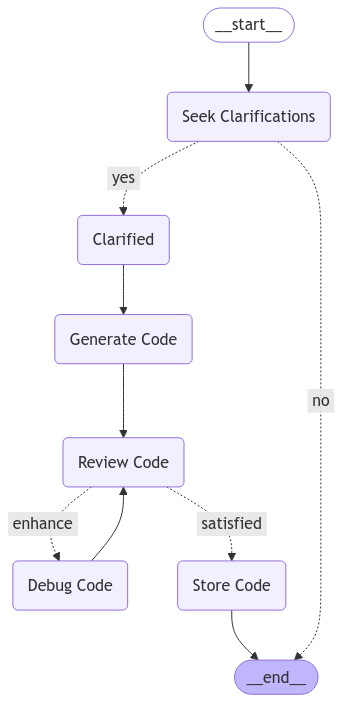

In [100]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [89]:
thread = {"configurable": {"thread_id": 22}}

SRS = read_file.invoke({"file_path": "input/srs.md"})
HLD = read_file.invoke({"file_path": "input/hld.md"})
FORMAT = read_file.invoke({"file_path": "input/ps.md"})

#print(readfile)

count = 1

while True:
    user = input("User (q/Q to quit): ")
    if user.lower() in ["quit", "q", "Q"]:
        print("AI: Byebye")
        break
    output = None
    
    #print(count)
    user_msg = user + " \n SRS:" + SRS + " \n HLD:" + HLD + " \n Project Structure:" + FORMAT 
    #print(count)    
    for output in graph.stream(
        {
            "messages": [HumanMessage(content=user_msg)],
            "srs": [HumanMessage(content=SRS)],
            "hld": [HumanMessage(content=HLD)],
            "iteration" : 1,
            "max_iteration": 2,
        }, 
        config=thread, 
        stream_mode="updates"):
        #print(output)
        for key, value in output.items():
            print("***** Result from Agent: ",key)
            print("***** value: ",value)



User (q/Q to quit):  hi


**** continue_conversation *****
***** Result from Agent:  information_gathering
***** value:  {'messages': [AIMessage(content='Thank you for providing the Software Requirements Specification (SRS) and High-Level Design (HLD) documents for the web-based task management application. I have reviewed both documents thoroughly.\n\n### Understanding Summary:\n1. **Purpose**: The application is designed to manage tasks for users and teams, enhancing productivity and collaboration.\n2. **Core Features**:\n   - Task creation, assignment, and status tracking.\n   - Notifications for task updates and due dates.\n   - Reporting on task progress and completion.\n3. **Architecture**: The application will utilize a microservices architecture with an API Gateway, Task Management Service, Notification Service, and Reporting Service.\n4. **Technology Stack**: The frontend will use Streamlit, while the backend will be built with Node.js or Java (Spring Boot). PostgreSQL will be used for the database, an

User (q/Q to quit):  proceed


**** conclude_conversation *****
***** Result from Agent:  information_gathering
***** value:  {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1D1NGlxaNW2hxOPqMc2BcnJk', 'function': {'arguments': '{"tech_stack":"Streamlit, Node.js, PostgreSQL, RabbitMQ","microservice_list":"API Gateway, Task Management Service, Notification Service, Reporting Service"}', 'name': 'CodeReq'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 3713, 'total_tokens': 3756, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 3584}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ab751633-4c24-484f-b660-0869ed9fa168-0', tool_calls=[{'name': 'CodeReq', 'args': {'tech_stack': '

User (q/Q to quit):  q


AI: Byebye


In [58]:
import os
import re

def extract_and_write_files(content):
    """
    Extracts code blocks and their corresponding file paths from the given content,
    then writes the code to appropriate files while maintaining the directory structure.

    Args:
    content (str): The input Markdown-like text with code blocks.

    Returns:
    None
    """
    # Regex patterns
    file_and_code_pattern = re.compile(
        r"(?<=\*\*)([^\n*]+)\*\*\s*```(?:\w+)?\n(.*?)```",
        re.DOTALL
    )


    # Find all matches for file paths and code blocks
    matches = file_and_code_pattern.findall(content)

    if not matches:
        print("No code blocks found in the content.")
        return

    for file_path, code in matches:
        # Validate the file path (skip if it's not valid)
        if not is_valid_file_path(file_path):
            print(f"Skipping invalid file path: {file_path}")
            continue

        write_code_to_file(file_path.strip(), code.strip())

def is_valid_file_path(file_path):
    """
    Validates if a given file path is likely to be valid.

    Args:
    file_path (str): The file path to validate.

    Returns:
    bool: True if valid, False otherwise.
    """
    # Basic validation: file path should contain a directory and a file name
    return "/" in file_path and file_path.endswith(('.py', '.md', '.txt', '.sh', '.json', '.yaml', '.yml'))

def write_code_to_file(file_path, code):
    """
    Creates directories and writes code to a specified file.

    Args:
    file_path (str): The file path where the code should be written.
    code (str): The code content to write.

    Returns:
    None
    """
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Write the code to the file
    with open(file_path, "w") as file:
        file.write(code)
    print(f"Written to {file_path}")

# Example usage
content = read_file.invoke({"file_path": "output/code v0.1.md"})
extract_and_write_files(content)


Written to task_management_service/app.py
Written to task_management_service/models.py
Written to task_management_service/routes.py
Written to task_management_service/test/test_routes.py
Written to notification_service/app.py
Written to reporting_service/app.py


In [ ]:
import os

# Define the content and file paths
files = read_file.invoke({"file_path": "output/code v0.1.md"})
print(files)
# Create the directories and files
for file_path, content in files.items():
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Write the content to the file
    with open(file_path, "w") as file:
        file.write(content)

print("Files created successfully.")
